In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [7]:
data_dir = os.getcwd() + "/datos"
metadata = pd.read_csv(data_dir + '/HAM10000_metadata.tab', delimiter="\t",
                    names = ["lesion_id", "image_id", "dx", "dx_type",
                    "age", "sex", "localization", "label"])

# label encoding the seven classes for skin cancers
le = LabelEncoder()
le.fit(metadata['dx'])
print("Classes:", list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
6547,HAM_0002029,ISIC_0030270,nv,follow_up,50.0,male,abdomen,5
1016,HAM_0006533,ISIC_0028497,bkl,consensus,80.0,male,face,2
5803,HAM_0000939,ISIC_0028620,nv,follow_up,35.0,female,trunk,5
2430,HAM_0007532,ISIC_0024662,vasc,consensus,75.0,male,trunk,6
2897,HAM_0006904,ISIC_0027281,bcc,histo,70.0,male,back,1
9048,HAM_0002754,ISIC_0025892,nv,histo,40.0,female,lower extremity,5
7487,HAM_0002641,ISIC_0034111,nv,histo,40.0,female,back,5
3790,HAM_0000686,ISIC_0031523,nv,follow_up,65.0,female,trunk,5
8388,HAM_0005761,ISIC_0029493,nv,histo,30.0,male,lower extremity,5
2844,HAM_0007627,ISIC_0026118,bcc,histo,80.0,male,chest,1


In [9]:
import numpy as np

In [11]:
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']

def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = metadata[metadata['dx']==str(l)]['dx'].value_counts()[0]
    counts = counts.astype(float)
    median_freq = np.median(counts)
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

classweight= estimate_weights_mfb(label)
for i in range(len(label)):
    print(label[i],":", classweight[i])
    

akiec : 1.5718654434250765
bcc : 1.0
bkl : 0.467697907188353
df : 4.469565217391304
mel : 0.4618149146451033
nv : 0.07665920954511558
vasc : 3.619718309859155


In [34]:
import shutil

In [45]:
data_dir = os.getcwd() + "/datos/imagenes_train"

# A path to the folder where you want to store the rearranged images:
dest_dir = os.getcwd() + "/datos/imagenes_train_mod/"

# Read the metadata file:
label = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
label_images = []

# Copy the images into new folder structure:
for i in label:
    os.mkdir(dest_dir + str(i))
    sample = metadata[metadata['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]    

In [13]:
import torch
from torchvision import transforms

In [14]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 10
validation_batch_size = 10

# We compute the weights of individual classes and convert them to tensors
class_weights = estimate_weights_mfb(label)
class_weights = torch.FloatTensor(class_weights)

transform_train = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
import torchvision

In [18]:
test_size = 0.2
val_size = 0.2

In [19]:
class StratifiedSampler:
    """Stratified Sampling
    Provides equal representation of target classes
    """
    def __init__(self, class_vector, test_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = torch.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [53]:
dataset = torchvision.datasets.ImageFolder(root = dest_dir)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))

Train Data Size: 6409
Test Data Size: 2003
Validation Data Size: 1603


In [55]:
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= dest_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root = dest_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=test_samples)

In [27]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


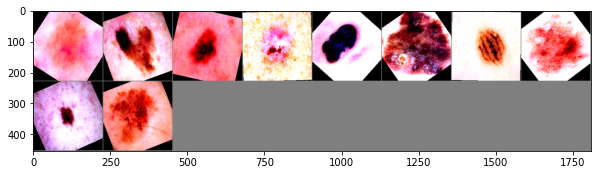

In [56]:
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels


In [58]:
import torch.nn as nn

In [69]:
import torch.nn.functional as F

In [70]:
class RedNeuronal(nn.Module):
    def __init__(self, num_classes):
        super(RedNeuronal, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*54*54, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [75]:
import torch.optim as optim
net = RedNeuronal(7).to("cuda")
criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-5)

In [83]:
# number of loops over the dataset
num_epochs = 100
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        corr = sum(predicted == labels).item() / len(labels)
        num_samples_total +=len(labels)
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total

    # val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    # print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    # val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    # val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 1.781  Accuracy:0.053
Epoch: 2
Loss: 1.636  Accuracy:0.054
Epoch: 3
Loss: 1.574  Accuracy:0.054
Epoch: 4
Loss: 1.533  Accuracy:0.054
Epoch: 5
Loss: 1.504  Accuracy:0.055
Epoch: 6
Loss: 1.479  Accuracy:0.055
Epoch: 7
Loss: 1.452  Accuracy:0.056


KeyboardInterrupt: 

In [ ]:
epoch = range(1, num_epochs+1)

# Plot the Loss curves
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

#Plot the Accuracy curves
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()